# Сборный проект. Прогнозирование успешности компьютерных игр.

В нашем распоряжении таблица с данными о продажах видео-игр по регионам, а так же рейтинге этих игр - экспертной оценке и оценке юзеров, а также возрастной группе. <br><br>
**Цель исследования:** На основе данных из открытых источников необходимо спрогнозировать успешность видео-игр на 2017 год, основываясь на данных по предыдущим годам. <br><br>
Основной показатель успешности компьютерной игры - это сумма продаж (кол-во проданных единиц продукции), т.е. индикатор популярности игры. Вторичным показателем успешности игры является ее высокий рейтинг среди критиков и юзеров. <br>
Мы исследуем взаимосвязи суммы продаж и платформы, жанра, года релиза, рейтингов.<br><br>
**План исследования:** <br>
1. Провести анализ количества игр по годам и по платформам, отбросить устаревшие данные.<br>
2. Проанализировать динамику продаж на различных платформах. <br>
3. Прояснить различия между профилями клиентов по регионам. <br>
4. Проверить следующие гипотезы: о равенстве средних рейтингов платформ Xbox One &  PC; о неравенстве средних рейтингов жанров Action & Sports. 

## Чтение и предобработка данных

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import stats as st

In [2]:
# чтение файла
data = pd.read_csv('/datasets/games.csv')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


**Вывод**: Общее количество строк - 16715, в столбцах Name, Year_of_release, Genre, Critic_Score, User_score, Rating пропущены значения.


In [3]:
# приведем названия столбцов к нижнему регистру
data.columns = data.columns.str.lower()
data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

In [4]:
data.duplicated().sum()

0

Явных дубликатов в таблице нет. <br>
Изучим поподробнее пропуски.

In [5]:
# посмотрим на строки с пропущенными значениями столбца Name
display(data[data['name'].isna()== True])
# данные за 1993 год с очень малыми продажами - можем пренебречь этими двумя строками (эти же строки выводятся 
# в статистике null'овых значений по столбцу genre; убьем одним махом двух зайцев)
data = data.dropna(subset = ['name'])

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


In [6]:
# посмотрим на строки с пропущенными значениями столбца year of release
display(data[data['year_of_release'].isna()== True])
# посчитаем долю кол-ва пропущенных значений от всего кол-ва строк
data['year_of_release'].isna().sum() / data['year_of_release'].isna().count()*100
# всего 1,6% - это немного, можем удалить эти строки, их потеря не повлияет существенно на результаты анализа
data = data.dropna(subset = ['year_of_release'])

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16373,PDC World Championship Darts 2008,PSP,NaN,Sports,0.01,0.00,0.00,0.00,43.0,tbd,E10+
16405,Freaky Flyers,GC,NaN,Racing,0.01,0.00,0.00,0.00,69.0,6.5,T
16448,Inversion,PC,NaN,Shooter,0.01,0.00,0.00,0.00,59.0,6.7,M
16458,Hakuouki: Shinsengumi Kitan,PS3,NaN,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN


In [7]:
# посмотрим на строки с пропущенными значениями столбца critic_score
display(data[data['critic_score'].isna()== True])

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN
10,Nintendogs,DS,2005.0,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


Строк с Nan много, но мы не можем избавиться от них, т.к. будет утеряно много ценных данных для анализа по продажам, в том числе за последние года. Мы отфильтруем эти значения позже, при анализе корреляции оценки и продаж.

In [8]:
# необходимо привести столбцы к правильному типу: int64 для столбца year of release, float для столбца user_score
data['year_of_release'].unique()
data['year_of_release'].value_counts()
data['year_of_release'].isnull().sum() /  data['year_of_release'].isnull().count()*100
data['year_of_release'] = data['year_of_release'].astype('int')
#data.info()

In [9]:
# 'user_score' не может быть напрямую переведен в тип float, т.к. содержит заменитель пропуска "tbd" ("to be defined"), 
# т.е. этот рейтинг должны (или собирались) определить в будущем. Посмотрим на строки с пропущенными значениями столбца year of release
display(data[data['user_score']== 'tbd'])

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,Zumba Fitness,Wii,2010,Sports,3.45,2.59,0.0,0.66,NaN,tbd,E
301,Namco Museum: 50th Anniversary,PS2,2005,Misc,2.08,1.35,0.0,0.54,61.0,tbd,E10+
520,Zumba Fitness 2,Wii,2011,Sports,1.51,1.03,0.0,0.27,NaN,tbd,T
645,uDraw Studio,Wii,2010,Misc,1.65,0.57,0.0,0.20,71.0,tbd,E
718,Just Dance Kids,Wii,2010,Misc,1.52,0.54,0.0,0.18,NaN,tbd,E
...,...,...,...,...,...,...,...,...,...,...,...
16695,Planet Monsters,GBA,2001,Action,0.01,0.00,0.0,0.00,67.0,tbd,E
16697,Bust-A-Move 3000,GC,2003,Puzzle,0.01,0.00,0.0,0.00,53.0,tbd,E
16698,Mega Brain Boost,DS,2008,Puzzle,0.01,0.00,0.0,0.00,48.0,tbd,E
16704,Plushees,DS,2008,Simulation,0.01,0.00,0.0,0.00,NaN,tbd,E


In [10]:
data['user_score'] = data['user_score'].replace({'tbd':np.nan})
data['user_score'] = data['user_score'].astype('float')
data['user_score'].value_counts()

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   float64
 10  rating           9768 non-null   object 
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


В столбцах critic_score & user_score много пропущенных значение - оценка этих игр не была определена. Можно заменить NaN на 0, принимая для нашего исследования как данность, что 0 в этих столбцах не означает плохую оценку, а означает отсутствие оценки.

In [11]:
data['critic_score'] = data['critic_score'].fillna(0)
data['user_score'] = data['user_score'].fillna(0)
data['rating'] = data['rating'].fillna("0")
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     16444 non-null  float64
 9   user_score       16444 non-null  float64
 10  rating           16444 non-null  object 
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


In [12]:
# добавим столбец с общими продажами по всем трем регионам
data.insert(8, 'total_sales', data['na_sales']+ data['eu_sales'] + data['jp_sales'] +data['other_sales'])
data.head()


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,total_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,82.54,76.0,8.0,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,40.24,0.0,0.0,0
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,35.52,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,32.77,80.0,8.0,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,31.38,0.0,0.0,0


В качестве предобработки данных мы сделали следующее: <br>
1) привели названия столбцов к строчному регистру <br>
2) проанализировали столбцы на пропуски и избавились от null'овых значений в столбцах name, genre и year_of_release. Значения в этих столбцах критически важны для анализа, а заменить их мы ничем не можем, т.к. не располагаем достаточной информацией. В то же время, количество пропущенных строк менее 2% от общего датасета, так что можно этими данными пренебречь. <br>
3) также обнаружены пропуски в столбцах critic_score, user_score, rating, но количество пропусков в этих строках велико (около половины) и мы не можем просто удалить их.  Мы заменили их на 0, принимая как данность, что в данном контексте 0 - это не низкий рейтинг, а отсутствие рейтинга. <br>
Мы отфильтруем null'овые значения при детальном анализе именно рейтинга и скоринга, а для анализа по продажам и годам будем использовать эти строки наравне с другими. <br>
4) данные по столбцу year_of_release приведены к целочисленному типу, а данные по столбцу user_score - к типу float.<br>
5) добавили столбец с общими продажами по всем регионам.

## Анализ данных

### Анализ количества игр по годам и определение актуального периода

In [13]:
data.pivot_table(index = 'year_of_release', values = ['name', 'total_sales'], aggfunc = {'total_sales':'mean','name':'count'}).sort_values(by ='year_of_release')

,name,total_sales
year_of_release,,
1980,9,1.264444
1981,46,0.775652
1982,36,0.802222
1983,17,0.988235
1984,14,3.596429
1985,14,3.853571
1986,21,1.765714
1987,16,1.356250
1988,15,3.147333


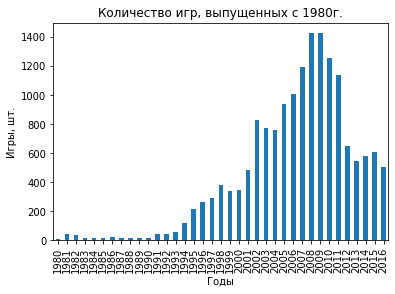

In [14]:
data.pivot_table(index = 'year_of_release', 
                 values = 'name', 
                 aggfunc = 'count').sort_values(by ='year_of_release').plot(kind ='bar', 
                                                                            legend = False, 
                                                                            title = 'Количество игр, выпущенных с 1980г.')
plt.xlabel('Годы')
plt.ylabel('Игры, шт.')
plt.show();

Пиковые годы - с 2005 по 2011, когда выходило максимальное количество игр в год (1000 и больше). Данные за 1993 и ранее можно отбросить, в те годы выпускалось менее 100 игр в год.

In [15]:
data = data.query('year_of_release > 1993')

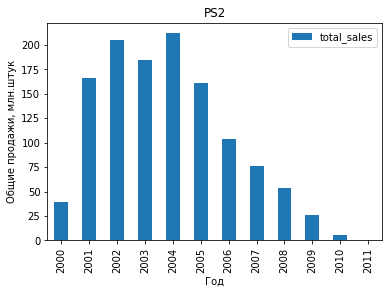

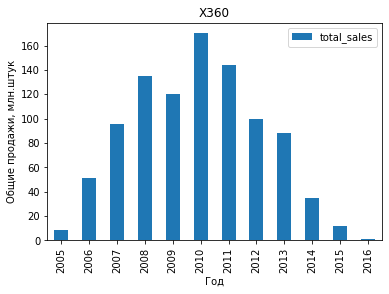

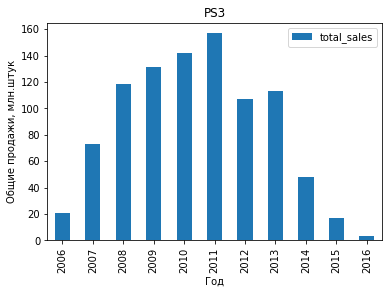

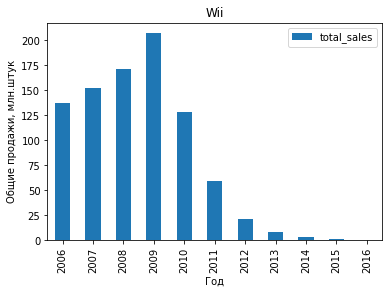

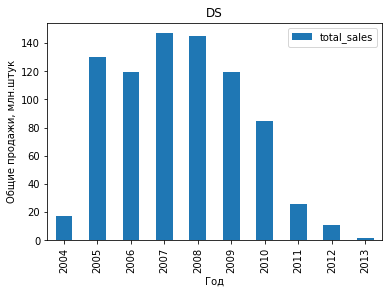

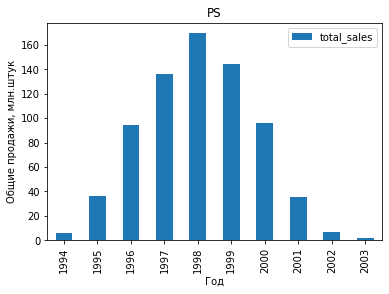

In [16]:
# построим графики по нескольким значимым платформам
platform_list = data.pivot_table(index = 'platform', values = 'total_sales', aggfunc='sum').sort_values(by ='total_sales', ascending = False)
platform_list = platform_list.query('total_sales > 700')
platform_pivot=data.query('platform in @platform_list.index').pivot_table(index = ['platform','year_of_release'], values = 'total_sales', aggfunc='sum').fillna(0)
for platform in platform_list.index:
    platform_pivot.loc[platform].plot(kind = 'bar', title = platform)
    plt.xlabel('Год')
    plt.ylabel('Общие продажи, млн.штук')

По графикам видно, что, как правило, на одной платформе игры выпускаются в течение 10 лет. Пиковые продажи в большинстве случаев приходятся на середину периода. То есть время существования одной платформы - примерно 10 лет. <br><br>
Для целей проекта нам необходимо определить, какие данные являются актуальныим и могут быть использованы для прогнозирования на 2017 год. Нам необходимо брать данные только по тем платформам, которые продаются в этом году.

In [17]:
# отфильтруем все платформы, которые продаются на данный момент
pf_list = data.query('year_of_release ==2016')['platform'].unique()
data.query('platform in @pf_list').pivot_table(index = 'platform', columns = 'year_of_release', values = 'total_sales', aggfunc = 'sum').fillna('')

year_of_release,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
platform,,,,,,,,,,,,,,,,,,,,,
3DS,,,,,,,,,,,...,,,,,63.2,51.36,56.57,43.76,27.78,15.14
PC,12.87,4.22,10.58,11.27,3.26,4.74,4.66,5.47,8.57,8.84,...,9.28,12.42,16.91,24.28,35.03,23.22,12.38,13.28,8.52,5.25
PS3,,,,,,,,,,,...,73.19,118.52,130.93,142.17,156.78,107.36,113.25,47.76,16.82,3.60
PS4,,,,,,,,,,,...,,,,,,,25.99,100.00,118.90,69.25
PSV,,,,,,,,,,,...,,,,,4.63,16.19,10.59,11.90,6.25,4.25
Wii,,,,,,,,,,,...,152.77,171.32,206.97,127.95,59.65,21.71,8.59,3.75,1.14,0.18
WiiU,,,,,,,,,,,...,,,,,,17.56,21.65,22.03,16.35,4.60
X360,,,,,,,,,,,...,95.41,135.26,120.29,170.03,143.84,99.74,88.58,34.74,11.96,1.52
XOne,,,,,,,,,,,...,,,,,,,18.96,54.07,60.14,26.15


По таблице видно, что начиная с 2013 года в продаже появляются игры по всем актуальным на данный момент платформам. Примем этот промежуток с 2013 по 2016 как актуальные данные, подходящие для прогноза.

In [18]:
# самые актуальные платформы
actual_data = data.query('year_of_release >= 2013 & platform in @pf_list')
actual_pivot = actual_data.pivot_table(index = 'platform', columns ='year_of_release', values = 'total_sales', aggfunc = 'sum').fillna('')
actual_pivot

year_of_release,2013,2014,2015,2016
platform,,,,
3DS,56.57,43.76,27.78,15.14
PC,12.38,13.28,8.52,5.25
PS3,113.25,47.76,16.82,3.60
PS4,25.99,100.00,118.90,69.25
PSV,10.59,11.90,6.25,4.25
Wii,8.59,3.75,1.14,0.18
WiiU,21.65,22.03,16.35,4.60
X360,88.58,34.74,11.96,1.52
XOne,18.96,54.07,60.14,26.15


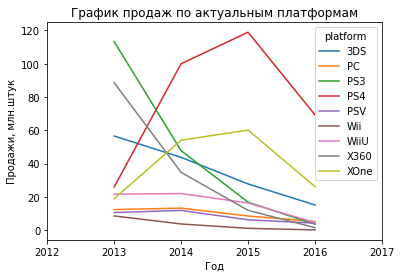

In [19]:
actual_pivot.T.plot(title = 'График продаж по актуальным платформам')
plt.xlabel('Год')
plt.ylabel('Продажи, млн.штук')
plt.xlim(2012, 2017);

Мы отобрали только те платформы, которые имели продажи в 2016 году, т.к. если на какой-то платформе игры перестали выходить в 2016, то уже в 2017 их точно не будет - это видно из графиков продаж по платформам - они не прерываются. <br>
Наиболее перспективными представляются платформы, которые находятся в начале или середине жизненного цикла - их продажи будут максимальны в ближайший год. Судя по графику, это **PS4, XOne, 3DS**. Так же можно добавить **WiiU** в этот список, хотя его продажи в 2016 значительно снизились по сравнению с 2015. Но это скорее всего связано, что статистика продаж за 2016 не полная. <br>
Явным образом на спад идут **PS3, X360, Wii**. Этот факт тоже должен быть учтен в рекомендациях.

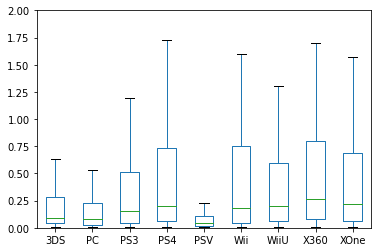

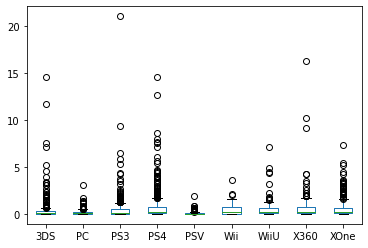

In [20]:
# построим график "ящик с усами" по платформам
actual_data.pivot_table(
        index= 'name', 
        columns = 'platform', 
        values = 'total_sales').boxplot(meanline=True, showcaps=True, 
                showbox=True, showfliers=False, grid = False)
plt.ylim(0, 2)
plt.show();

actual_data.pivot_table(
        index= 'name', 
        columns = 'platform', 
        values = 'total_sales').boxplot(meanline=True, showcaps=True, 
                showbox=True, grid = False)

plt.show();

На графике видно, что по платформам PS3, PS4, X360, XOne медианные продажи выше, чем по другим платформам, а разброс значений достаточно большой. Из этого можно сделать вывод, что отдельные игры на этих платформах имеют более высокие продажи с большей долей вероятности, чем по другим. <br> Соответственно, можно рекомендовать обратить внимание на эти платформы.

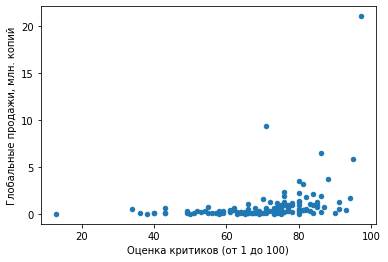

0.2792743632324718

In [21]:
# возьмем одну из популярных платформ - PS3 -  и изучим корреляцию продаж и скоринга
correl_data = actual_data.query('platform == "PS3" & total_sales>0')[['total_sales', 'critic_score', 'user_score']]
correl_data.query('critic_score >0').plot(kind = 'scatter', x='critic_score', y = 'total_sales') # уберем нулевые значения, которыми мы вначале заменяли NaN
plt.ylabel('Глобальные продажи, млн. копий')
plt.xlabel('Оценка критиков (от 1 до 100)')
plt.show();
correl_data['critic_score'].corr(correl_data['total_sales'])

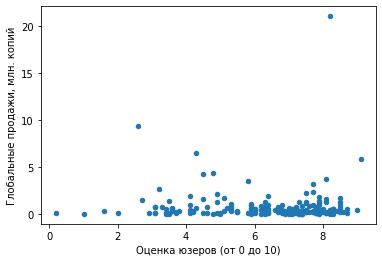

0.20209116183305123

In [22]:
correl_data.query('user_score >0').plot(kind = 'scatter', x='user_score', y = 'total_sales') # уберем нулевые значения, которыми мы вначале заменяли NaN
plt.ylabel('Глобальные продажи, млн. копий')
plt.xlabel('Оценка юзеров (от 0 до 10)')
plt.show();
correl_data['user_score'].corr(correl_data['total_sales'])

Очевидно, что особой корреляции между продажами и оценками экспертов / клиентов не наблюдается. <br> Хотя по графику и заметно, что по-настоящему успешными в продажах смогли стать только игры с высоким рейтингом (70 и более). Но обратной зависимости не наблюдается - даже игры с крайне высоким (от 90  до 100) экспертным рейтингом могли иметь не очень высокие продажи. <br>
Однозначного вывода о продажах по экспертному рейтингу сделать нельзя.

In [23]:
#сравним результаты с корреляцией на других платформах
cor_pf = pd.DataFrame(index = ['critic_score', 'user_score'], columns = pf_list)
for platform in pf_list:
    cor_data = actual_data.query('platform == @platform')
    cor_pf.loc['critic_score', platform] = cor_data['critic_score'].corr(cor_data['total_sales'])
    cor_pf.loc['user_score', platform] = cor_data['user_score'].corr(cor_data['total_sales'])
    
cor_pf.T

,critic_score,user_score
PS4,0.22755,0.113116
3DS,0.061113,0.047497
XOne,0.274839,0.116563
WiiU,0.294148,0.252811
PS3,0.279274,0.202091
PC,0.1857,0.040887
X360,0.246573,0.068817
PSV,0.320714,0.324964
Wii,NaN,0.799656


Если проанализировать данные из таблицы с цифрами корреляции по актуальным платформам, видно, что в целом ситуация похожа на корреляцию по платформе PS3: слабый показатель корреляции Пирсона на уровне 0,2 - 0,3 для экспертных оценок и еще меньше - для оценок пользователей. <br>
Данные по экспертным оценкам Wii отсутствуют полностью, поэтому у нас стоит NaN, а по клиентским оценкам данных крайне мало, и они не показательны. Из-за этого данные по корреляции на платформе wii выбиваются из общей статистики.

Изучим распределение игр по жанрам, и выявим наиболее популярные.

In [24]:
# жанры за все время
data.pivot_table(index = 'genre', values = 'total_sales', aggfunc = {'sum', 'mean', 'count'}).sort_values(by ='mean', ascending = False)

,count,mean,sum
genre,,,
Platform,819,0.782161,640.59
Shooter,1258,0.776025,976.24
Role-Playing,1451,0.617229,895.60
Racing,1211,0.573567,694.59
Sports,2260,0.560504,1266.74
Action,3226,0.510422,1646.62
Fighting,814,0.504975,411.05
Misc,1707,0.454909,776.53
Simulation,849,0.449753,381.84


По таблице явно видны жанры-лидеры - это Platform и Shooter. Средние продажи в этих жанрах - 0,77 млн на одну игру. Adventure - явный аутсайдер (всего 0,166 млн на одну игру в среднем, хотя игр в таком жанре выпускается довольно много). <br>
Посмотрим, изменилась ли статистика предпочитаемых жанров за последнее десятилетие.

In [25]:
# жанры за актуальный период
genre_pivot= actual_data.pivot_table(index = 'genre',
                        values = 'total_sales', 
                        aggfunc = {'sum', 'mean', 'count'}).sort_values(by ='mean', ascending = False)
genre_pivot

,count,mean,sum
genre,,,
Shooter,187,1.245882,232.98
Sports,208,0.720817,149.93
Platform,72,0.582500,41.94
Role-Playing,285,0.508281,144.86
Racing,85,0.469294,39.89
Fighting,79,0.446709,35.29
Misc,146,0.428562,62.57
Action,752,0.426210,320.51
Simulation,61,0.353279,21.55


genre
Shooter         1.245882
Sports          0.720817
Platform        0.582500
Role-Playing    0.508281
Racing          0.469294
Name: mean, dtype: float64

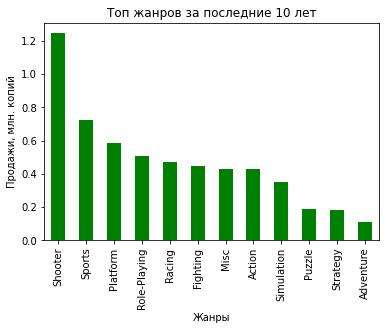

In [26]:
genre_pivot['mean'].plot(kind = 'bar', title= 'Топ жанров за последние 10 лет', color='green')
plt.xlabel('Жанры')
plt.ylabel('Продажи, млн. копий');
genre_pivot[0:5]['mean'] # топ-5 жанров

Топ-5 жанров в последние 10 лет те же, что в среднем за все время: Shooter, Sports, Platform, Role-playing, Racing. Очевидно, за последние годы шутеры набирают все большую популярность и вышли на первое место. Adventure по-прежнему в аутсайдерах.

### Профиль пользователей разных регионов

Определим для пользователя каждого региона (NA, EU, JP): <br>
•	Самые популярные платформы (топ-5);<br>
•	Самые популярные жанры (топ-5);<br>
•	Влияет ли рейтинг ESRB на продажи в отдельном регионе<br>


In [27]:
# для начала сгруппируем данные по регионам. Каждому региону соответствуют данные, где есть продажи (>0)
na_data = actual_data.query('na_sales >0')
eu_data = actual_data.query('eu_sales >0')
jp_data = actual_data.query('jp_sales >0')

Топ-5 жанров по Северной Америке


,na_sales
platform,
PS4,108.74
XOne,93.12
X360,81.66
PS3,63.50
3DS,38.20


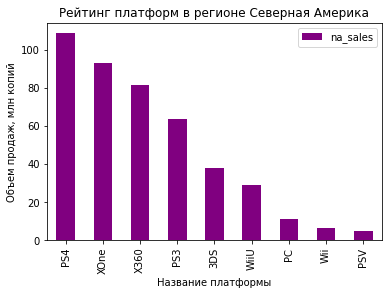

Топ-5 жанров по Европе


,eu_sales
platform,
PS4,141.09
PS3,67.81
XOne,51.59
X360,42.52
3DS,30.96


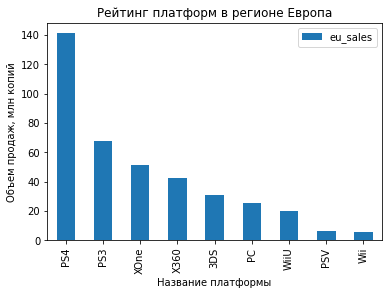

Топ-5 жанров по Японии


,jp_sales
platform,
3DS,67.81
PS3,23.35
PSV,18.59
PS4,15.96
WiiU,10.88


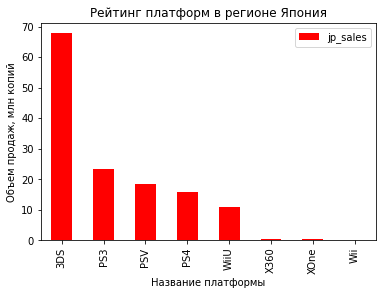

In [28]:
# Top-5 платформ
top_pf_na = na_data.pivot_table(index = 'platform',
                    values = 'na_sales', 
                    aggfunc ='sum').sort_values(by = 'na_sales', ascending = False)
print('Топ-5 жанров по Северной Америке')
display(top_pf_na[0:5])
top_pf_na.plot(kind ='bar', title = 'Рейтинг платформ в регионе Северная Америка', color = 'purple');
plt.xlabel('Название платформы')
plt.ylabel('Объем продаж, млн копий')
plt.show();

top_pf_eu = eu_data.pivot_table(index = 'platform',
                    values = 'eu_sales', 
                    aggfunc ='sum').sort_values(by = 'eu_sales', ascending = False)
print('Топ-5 жанров по Европе')
display(top_pf_eu[0:5])
top_pf_eu.plot(kind ='bar', title = 'Рейтинг платформ в регионе Европа');
plt.xlabel('Название платформы')
plt.ylabel('Объем продаж, млн копий')
plt.show();

top_pf_jp = jp_data.pivot_table(index = 'platform',
                    values = 'jp_sales', 
                    aggfunc ='sum').sort_values(by = 'jp_sales', ascending = False)
print('Топ-5 жанров по Японии')
display(top_pf_jp[0:5])
top_pf_jp.plot(kind ='bar', title = 'Рейтинг платформ в регионе Япония', color = 'red');
plt.xlabel('Название платформы')
plt.ylabel('Объем продаж, млн копий');

Посмотрим, как ведет себя каждая платформа в трех регионах.

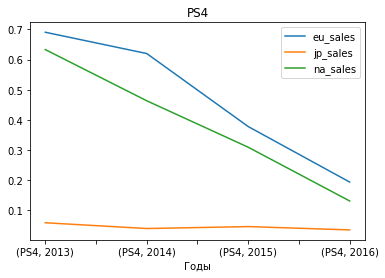

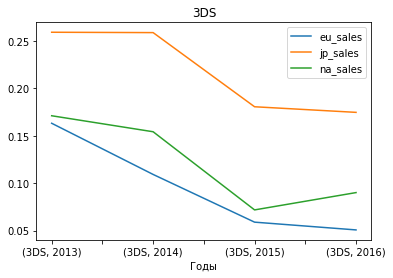

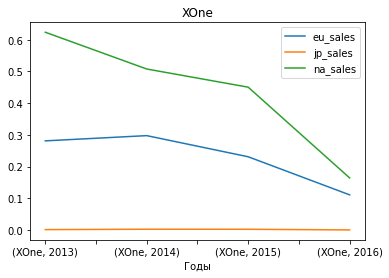

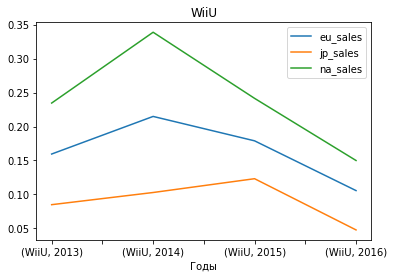

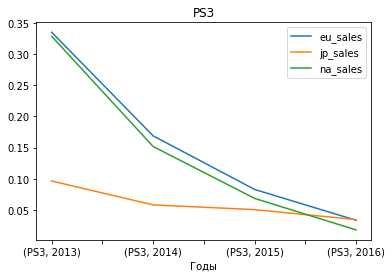

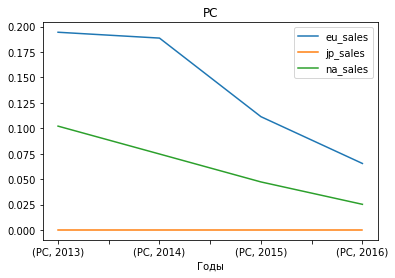

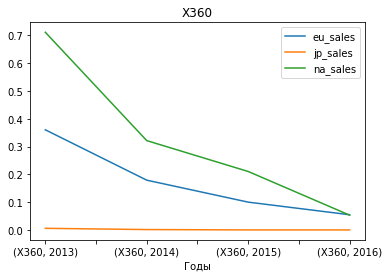

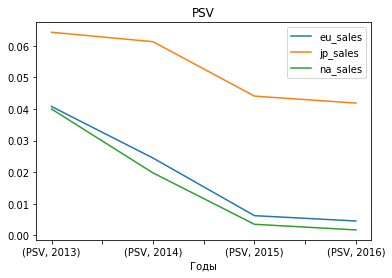

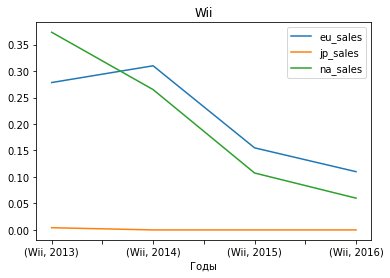

In [29]:
graph = actual_data.pivot_table(index = ['platform', 'year_of_release'],
                        values ={'na_sales', 'jp_sales', 'eu_sales'})
for pf in pf_list:
    graph.query('platform == @pf').plot(title = pf)
    plt.xlabel('Годы');

Графики тренда продаж почти у каждой платформы нисходящие к 2016 году, но это скорее всего связано с тем, что данные за 2-16 год неполные. <br>
Главный вывод из этих графиков: интересы клиентов из Северной Америки и Европы очень похожи (соответственно, и продажи по платформам тоже), а вот для Японии характерны особенности. <br><br>
В Японии почти не продаются игры на платформах PS4, XOne, PC, X360, Wii, зато гораздо больше, чем в других регионах, популярна платформа **PSV**. Наибольший интерес в этой стране так же представляет **3DS**. <br><br>
В Северной Америке и Европе, судя по графика, умирающими являются платформы PS3, PSV, X360 и, возможно, Wii и PS4. Для этих регионов можно рекомендовать в качестве наиболее высокопотенциальных **XOne, WiiU, 3DS. PC** это стабильная платформа с долгой историей, и ее тоже в принципе можно порекомендовать.

Топ-5 жанров по Северной Америке


,na_sales
genre,
Action,125.83
Shooter,109.74
Sports,65.27
Role-Playing,46.40
Misc,27.46


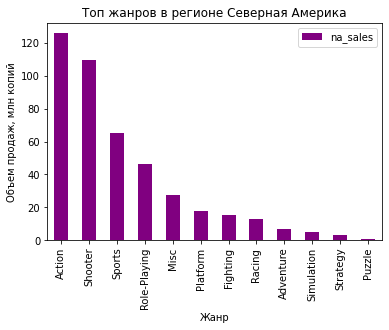

Топ-5 жанров по Европе


,eu_sales
genre,
Action,117.87
Shooter,87.86
Sports,60.34
Role-Playing,36.97
Racing,20.19


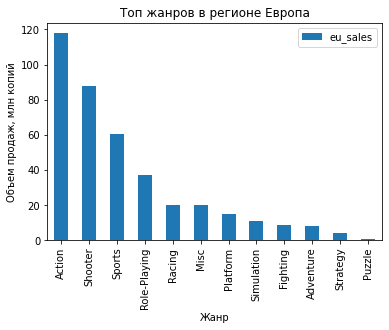

Топ-5 жанров по Японии


,jp_sales
genre,
Role-Playing,50.01
Action,39.65
Misc,9.03
Fighting,7.63
Shooter,6.61


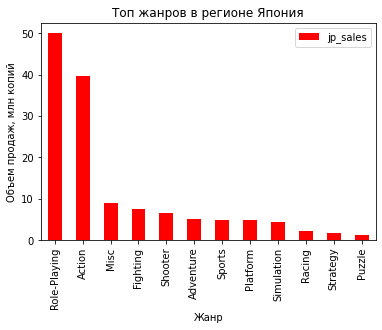

In [30]:
# Top-5 жанров
top_genre_na = na_data.pivot_table(index = 'genre',
                    values = 'na_sales', 
                    aggfunc ='sum').sort_values(by = 'na_sales', ascending = False)
print('Топ-5 жанров по Северной Америке')
display(top_genre_na[0:5])
top_genre_na.plot(kind ='bar', title = 'Топ жанров в регионе Северная Америка', color = 'purple');
plt.xlabel('Жанр')
plt.ylabel('Объем продаж, млн копий');
plt.show();

top_genre_eu = eu_data.pivot_table(index = 'genre',
                    values = 'eu_sales', 
                    aggfunc ='sum').sort_values(by = 'eu_sales', ascending = False)
print('Топ-5 жанров по Европе')
display(top_genre_eu[0:5])
top_genre_eu.plot(kind ='bar', title = 'Топ жанров в регионе Европа');
plt.xlabel('Жанр')
plt.ylabel('Объем продаж, млн копий')
plt.show();

top_genre_jp = jp_data.pivot_table(index = 'genre',
                    values = 'jp_sales', 
                    aggfunc ='sum').sort_values(by = 'jp_sales', ascending = False)
print('Топ-5 жанров по Японии')
display(top_genre_jp[0:5])
top_genre_jp.plot(kind ='bar', title = 'Топ жанров в регионе Япония', color='red');
plt.xlabel('Жанр')
plt.ylabel('Объем продаж, млн копий');


Топ-5 жанров в Северной Америке и Европе совпадает почти полностью, а вот в Японии с большим отрывом лидирует Role-Playing (РПГ), а вот шутеры совсем не популярны, в отличие от других регионов, где они №3. Это несколько противоречит общему ТОПу, в котором шутеры занимают первое место - но это объясняется, видимо, высокими продажами в регионе others. <br>
Также в Японии игры в жанре Platform более популярны, чем Racing, поэтому они вошли в топ, в сравнении с Европой И С.А.

,eu_sales,jp_sales,na_sales
rating,,,
M,143.85,13.20,165.21
0,74.69,34.00,89.18
E,78.71,14.64,78.94
E10+,41.10,4.97,54.02
T,39.78,14.36,49.79


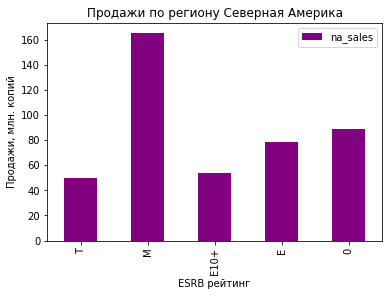

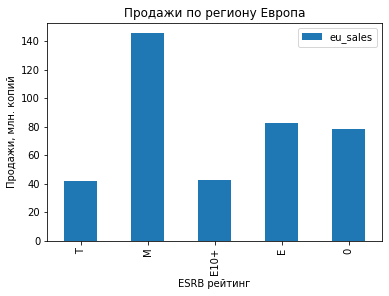

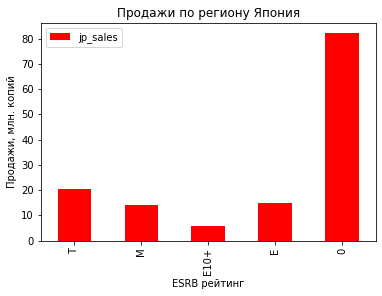

In [31]:
#влияет ли рейтинг ESRB на продажи?
# т.к. по категориальным данным, к которым относится рейтинг, мы не можем посчитать коэффициент корреляции Пирсона, 
# можно посмотреть распределение продаж по каждой оценке рейтинга
display(na_data.pivot_table(index = 'rating', values =['na_sales', 'eu_sales', 'jp_sales'], aggfunc ='sum').sort_values(by ='na_sales', ascending = False))

# визуализируем на графиках
na_data.pivot_table(index = 'rating', 
                    values ='na_sales', 
                    aggfunc ='sum').sort_values(by ='rating', 
                                                ascending = False).plot(kind = 'bar', 
                                                                        title = 'Продажи по региону Северная Америка',
                                                                        color = 'purple')
plt.xlabel('ESRB рейтинг')
plt.ylabel('Продажи, млн. копий');

eu_data.pivot_table(index = 'rating', 
                    values ='eu_sales', 
                    aggfunc ='sum').sort_values(by ='rating', 
                                                ascending = False).plot(kind = 'bar', 
                                                                        title = 'Продажи по региону Европа')
plt.xlabel('ESRB рейтинг')
plt.ylabel('Продажи, млн. копий');

jp_data.pivot_table(index = 'rating', 
                    values ='jp_sales', 
                    aggfunc ='sum').sort_values(by ='rating', 
                                                ascending = False).plot(kind = 'bar', 
                                                                        title = 'Продажи по региону Япония',
                                                                        color = 'red')
plt.xlabel('ESRB рейтинг')
plt.ylabel('Продажи, млн. копий');

Графики распределения суммарных продаж по Северной Америке и Европе практически идентичны, максимум продаж приходится на рейтинг "М" ("Взрослый"), следом идет "Е" ("Everyone" = "Все"). На третьем месте по продажам игры без рейтинга. Наименее востребованы игры Е10+ и Т (дети и подростки). <br>
В Японии подавляющее большинство проданных игр не имеет рейтинга. Видимо, в этой стране возрастной рейтинг не важен для пользователей, "все играют во всё".

## Проверка гипотез

**Гипотеза 1:** Средние пользовательские рейтинги платформ Xbox One и PC одинаковые (нулевая гипотеза). <br>
Альтернативная гипотеза: Средние пользовательские рейтинги этих платформ различаются.

In [38]:
data_xbox = actual_data.query('platform == "XOne"')['user_score'].dropna()
data_pc = actual_data.query('platform =="PC"')['user_score'].dropna()

alpha = 0.05

result = st.ttest_ind(data_xbox, data_pc) # мы не знаем дисперсии выборок, но оставим equal_var = True

print(f'P-value нулевой гипотезы: {result.pvalue}, а это значит, что...')
if result.pvalue < alpha:
    print('Нулевая гипотеза может быть отвергнута')
else:
    print('Нулевая гипотеза не может быть отвергнута')
    

P-value нулевой гипотезы: 0.24875948537089854, а это значит, что...
Нулевая гипотеза не может быть отвергнута


In [40]:
#посмотрим на вторичные показатели проверки гипотез: статистику разности и выборочные средние  
print(f'Статистика разности: {result.statistic}')
print(f'Выборочное среднее для Xbox One: {data_xbox.mean()}')
print(f'Выборочное среднее для PC: {data_pc.mean()}')

Статистика разности: -1.8162727286589562
Выборочное среднее для Action: 4.805263157894737
Выборочное среднее для Sports: 5.141798941798942


Нулевая гипотеза не может быть отвергнута, то есть - есть шанс, что средние генеральных совокупностей совпадают. Исходя из выборочных средних, можно действительно допустить, что оценки платформ совпадут - обе они около 5, хоть и есть определенный разброс.

**Гипотеза 2:** Средние пользовательские рейтинги жанров Action и Sports разные. <br>
Нулевая гипотеза: Средние рейтинги жанров совпадают. Альтернативная гипотеза: среднией рейтинги жанров различаются.

In [39]:
data_action = actual_data.query('genre == "Action"')['user_score'].dropna()
data_sports = actual_data.query('genre =="Sports"')['user_score'].dropna()

alpha = 0.05

result = st.ttest_ind(data_action, data_sports) # мы не знаем дисперсии выборок, но оставим equal_var = True

print(f'P-value нулевой гипотезы: {result.pvalue}, а это значит, что...')
if result.pvalue < alpha:
    print('Нулевая гипотеза может быть отвергнута')
else:
    print('Нулевая гипотеза не может быть отвергнута')


P-value нулевой гипотезы: 0.06964098496099129, а это значит, что...
Нулевая гипотеза не может быть отвергнута


Результат показал, что мы не можем отвергнуть гипотезу о том, что средние по двум жанрам совпадают, но статистическая значимость попадает в "сомнительный" промежуток: остаетстся 7% вероятности, что при тех средних, которые посчитаны для выборок по Action & Sports, средние генеральных совокупностей совпадают. То есть: 93% вероятности, что они различаются (наша задача доказать именно это). <br>
Т.к. это все же пограничное значение, следует посмотреть вторичные показатели статистической проверки гипотез: статистику разности и выборочные средние.

In [34]:
#посмотрим на вторичные показатели проверки гипотез: статистику разности и выборочные средние  
print(f'Статистика разности: {result.statistic}')
print(f'Выборочное среднее для Action: {data_action.mean()}')
print(f'Выборочное среднее для Sports: {data_sports.mean()}')

Статистика разности: 6.023752568091716
Выборочное среднее для Action: 3.929448233106014
Выборочное среднее для Sports: 3.3249999999999997


Статистика разности достаточно велика, а выборочные средние так же немного различаются. С учетом результата p-value, можно говорить о том, что наша гипотеза о том, что средние рейтинги для Action и Sports различаются, подтвердилась, во всяком случае, она точно не может быть отвергнута.

## Общий вывод

В нашей работе мы исследовали данные из открытых источников о продажах видео-игр за последние 40 лет в различных регионах. На основании этих данных мы провели анализ и пришли к следующим заключениям: <br>
1. При планировании продаж на 2017 год следует сфокусировать основное внимание на следующих платформах: **PS4, Xbox One, 3DS, WiiU**, т.к. эти платформы находятся в стадии активного роста. Среди жанров наиболее перспективными являются **Shooter, Racing, Sports, Platform, Aсtion и Role Playing** (засчет Японии).<br><br>
2. Профили покупателей в Северной Америке и Европе практически совпадают, а вот интересы клиентов в *Японии* отличаются: 
- они более всего заинтересованы в играх в жанре Role Playing и Action и совсем не заинтересованы в Shooter.<br>
- Они предпочитают платформы 3DS & PSV. <br>
- Они не обращают внимания на возрастной рейтинг. <br>
При этом покупатели в *Северной Америке и Европе*: <br>
- Интересуются бОльшим количеством платформ: это PS3/PS4, Wii / WiiU, Xbox One, 3DS. <br>
- Предпочитают следующие жанры: Shooter, Racing, Sports, Platform, Aсtion. <br>
- Больше всего покупают игры с возрастным ограничение М.<br><br>
3. Оценки, ни пользовательские, ни экспертные, напрямую не влияют на количество проданных копий, хотя игры-бестселлеры имели хорошие оценки.
<br><br>
4. Наша гипотеза о том, что рейтинг платформ Xbox One & PC одинаковый, не смогла быть опровергнута, а средние рейтинги (4,8 против 5,1) различаются не слишком сильно. <br>
Гипотеза о том, что средняя оценка игр в жанре Action & Sports не одинакова, подтвердилась (оценка Action'a больше).